# Custom `stats_model` Example
Using `LITMUS` but finding that the existing stats models just aren't what you're after: Good news, `LITMUS`'s modular design means you can write your own stats model or extend an existing one as easily as you like. In this example we'll show an example of adding PyRoa-style uncertainty calibration from an imaginary survey with two photometric telescopes. In this example we work in the format of a notebook, but in actuality you'd likely write your extension modules in a `.py` file

In [1]:
from litmus.models import _default_config, stats_model, quickprior
import litmus.gp_working as gpw
from litmus import *
from litmus._utils import dict_extend

import numpyro
import numpyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## An Imaginary Survey
First up, we need to actually generate our fake data. Let's imagine a ficticious (but reasonable) scenario like this:
1. Like OzDES, we have multi-year parallel observations of OzDES spectroscopy and DES-like phometry data for the first three years
2. Oops! Something went wrong and we lost the last three years of photometry!
3. Good news! A second survey (Let's call it DESOz) happened to observe the same target for the last three years!
4. Oh no! DESOZ has some unaccounted source of error $E_\mathrm{calib}$ that isn't accounted for in its measurement uncertainties!

This example may be a little unrealisitc, but it has the vague shape of a practical application and so we'll proceed anyway. First up, let's simulate the imaginary data, per usual equipped with all the true underlying values.

First, use the `mocks` module to get some OzDES/DES-like data:

In [2]:
seed = 0
mock_underlying = litmus.mocks.mock(seed=seed, lag=300, tau=500, maxtime=360 * 6, E=[0.01, 0.1])
phot_lc_1, spec_lc = mock_underlying.lc_1, mock_underlying.lc_2

Now, we'll trim the photometry lightcurve, `phot_lc_1`, to the first three years and generate a second mock with a _slightly_ higher measurement uncertainty, which we'll then trim to the _second_ three years. We'll then bring the "recorded" uncertainty back down. This means that the `phot_lc_2` now has its measurement uncertainty under-estimated, which we can see by how the corresponding points scatter about the true underlying lightcurve:

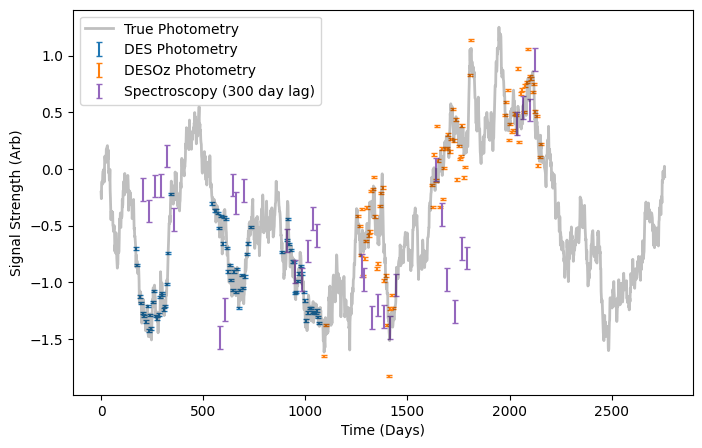

In [3]:
phot_lc_1 = phot_lc_1.trimmed_copy(0.0, 360 * 3)

E_calib_true = 0.2
mock_2 = litmus.mocks.mock(seed=seed, lag=300, tau=500, maxtime=360 * 6,
                           E=[np.sqrt(0.01 ** 2 + E_calib_true ** 2), 0.1])
phot_lc_2 = mock_2.lc_1.trimmed_copy(360 * 3, 360 * 6)
phot_lc_2.E = np.sqrt(phot_lc_2.E ** 2 - E_calib_true ** 2)

phot_lc = phot_lc_1.concatenate(phot_lc_2)

#-----------
fig, ax = plt.subplots(figsize=(8, 5))
phot_lc_1.plot(axis=ax, c='tab:blue', capsize=2, show=False, label="DES Photometry")
phot_lc_2.plot(axis=ax, c='tab:orange', capsize=2, show=False, label="DESOz Photometry")
spec_lc.plot(axis=ax, c='tab:purple', capsize=2, show=False, label="Spectroscopy (300 day lag)")
plt.plot(mock_underlying.lc.T, mock_underlying.lc.Y, alpha=0.25, lw=2, c='k', label="True Photometry")
plt.legend()
plt.ylabel("Signal Strength (Arb)")
plt.xlabel("Time (Days)")
plt.show()

## The Stats
Before we code a statistical model, we need to know what that model looks like exactly. In this case, it's a relatively simple change to the normal `GP_simple` model, but with one addition: we need `E_calib` to be some unknown factor near unity by which we correct the DESOz measurement errors. As a Bayesian model we need some sort of prior, and given we now that `E_calib` is close to zero an exponential distribution makes sense

\begin{equation}
\pi(E_\mathrm{calib}) \propto \exp(\lambda\times E_\mathrm{calib})
\end{equation}

Then we'd up-scale our uncertainties by this amount, remembering that we add errors in quadrature instead of linearly:
\begin{equation}
E_i = \sqrt{E_i^0 + E_\mathrm{calib}}  \;\; \forall \;\; i \in \{i_\mathrm{DESOz}\}
\end{equation}

Most of `LITMUS`'s models by default use uniform distributions, or at least distributions with hard boundaries, so we're playing a bit fast and loose with convention here. Still, for an ad-hoc example we can be a little shotgun with convention.

In NumPyro this looks something like:

```
E_calib = numpyro.sample('E_calib',numpyro.distributions.Exponential(0, lam))
E = jnp.sqrt(E**2 + jnp.where(survey=="DESOz", E_calib, 0.0)**2)

...Typical GP sampling stuf...
```

We need know we need to keep track of which survey generated each measurement in each lightcurve, so let's staple those onto the lightcurve objects now:

In [4]:
phot_lc.survey = [*["DES"] * sum(phot_lc.T < 360 * 3), *["DESOz"] * sum(phot_lc.T >= 360 * 3)]
spec_lc.survey = ["OzDES"] * spec_lc.N

## Building the `stats_model` Model

The minimum amount of things you need to build a `stats_model` in litmus is:
1. A way of turning lightcurves into data (`.lc_to_data()`),
2. A prior (`.prior()`), with default ranges (`._default_prior_ranges`), and
3. A model likelihood function (`.model_function(data)`)

Our model, lets call it `GP_simple_Ecalib` is an extension to the GP_simple model, so it inherits most of the bells and whistles out of the box. We only really need to specify the bits that change. Of the functions here, most are copy-pasted from the original `GP_simple` source-code with only a few extra lines added, but you can see how the moving parts work.

In [5]:
class GP_simple_Ecalib(litmus.models.GP_simple):
    def __init__(self, prior_ranges=None, **kwargs):
        self._default_prior_ranges = {
            'E_calib': [0, 1.0],
        }
        super().__init__(prior_ranges=prior_ranges, **kwargs)

    # ----------------------------------

    def lc_to_data(self, lc_1: lightcurve, lc_2: lightcurve) -> dict:
        T = jnp.array([*lc_1.T, *lc_2.T])
        Y = jnp.array([*lc_1.Y, *lc_2.Y])
        E = jnp.array([*lc_1.E, *lc_2.E])
        bands = jnp.array([*np.zeros(lc_1.N), *np.ones(lc_2.N)]).astype(int)
        survey = np.array([*lc_1.survey, *lc_2.survey])  # <---------- New!
        survey = jnp.where(survey == "DESOz", 1, 0)

        I = T.argsort()

        T, Y, E, bands = T[I], Y[I], E[I], bands[I]

        data = {'T': T,
                'Y': Y,
                'E': E,
                'bands': bands,
                "survey": survey  # <---------- New! 
                }

        return data

    def prior(self):
        lag, logtau, logamp, rel_amp, mean, rel_mean = super().prior()
        _, lam = self.prior_ranges['E_calib']  # <---------- New!
        E_calib = numpyro.sample('E_calib', dist.Exponential(lam))  # <---------- New!
        return lag, logtau, logamp, rel_amp, mean, rel_mean, E_calib

    def model_function(self, data):
        lag, logtau, logamp, rel_amp, mean, rel_mean, E_calib = self.prior()

        T, Y, E, bands, survey = [data[key] for key in ['T', 'Y', 'E', 'bands', "survey"]]

        E = jnp.sqrt(E ** 2 + jnp.where(survey == 1, E_calib, 1.0) ** 2)  # <---- The magic line!

        # Conversions to gp-friendly form
        amp, tau = jnp.exp(logamp), jnp.exp(logtau)

        diag = jnp.square(E)

        delays = jnp.array([0, lag])
        amps = jnp.array([amp, rel_amp * amp])
        means = jnp.array([mean, mean + rel_mean])

        T_delayed = T - delays[bands]
        I = T_delayed.argsort()

        # Build and sample GP

        gp = gpw.build_gp(T_delayed[I], Y[I], diag[I], bands[I], tau, amps, means, basekernel=self.basekernel)
        numpyro.sample("Y", gp.numpyro_dist(), obs=Y[I])

Now let's create an instance of this model and test to see if it actually works. First, we'll generate a bunch of samples to make sure it understands its prior properly:

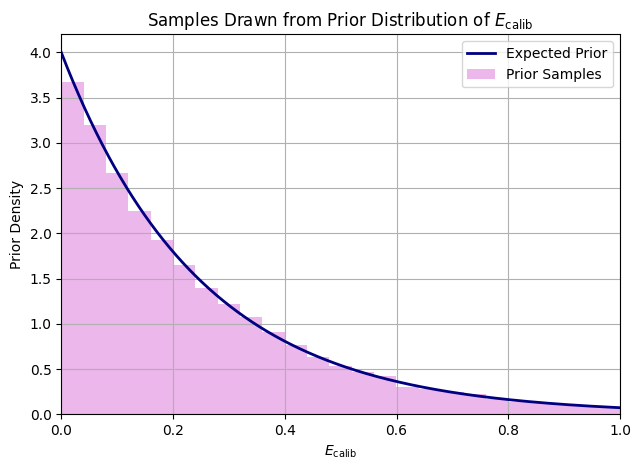

In [6]:
lam = 4.0
model_instance = GP_simple_Ecalib(prior_ranges={"E_calib":[0, lam]}, verbose=False)
prior_samples = model_instance.prior_sample(1024 * 32)

#--------
X = prior_samples['E_calib'].sort()
plt.plot(X, lam*np.exp(-X*lam), c= 'navy', lw=2, label = "Expected Prior")
plt.hist(prior_samples['E_calib'], bins=64, density=True, color = 'orchid', alpha = 0.5, label = "Prior Samples")
plt.title("Samples Drawn from Prior Distribution of $E_\mathrm{calib}$")
plt.xlabel("$E_\mathrm{calib}$"), plt.ylabel("Prior Density")
plt.legend(), plt.tight_layout()
plt.grid()
plt.xlim(0,1.0)
plt.show()

Let's also make sure that our statistical model has enough constraining power to actually _measure_ $E_\mathrm{calib}$, and confirm that `.model_function()` and `.lc_to_data()` are working properly. Because we chose a vague prior the posterior density is heavily likelihood dominated and, thankfully, near-gaussian which means we can safely use the `hessian_scan`. 

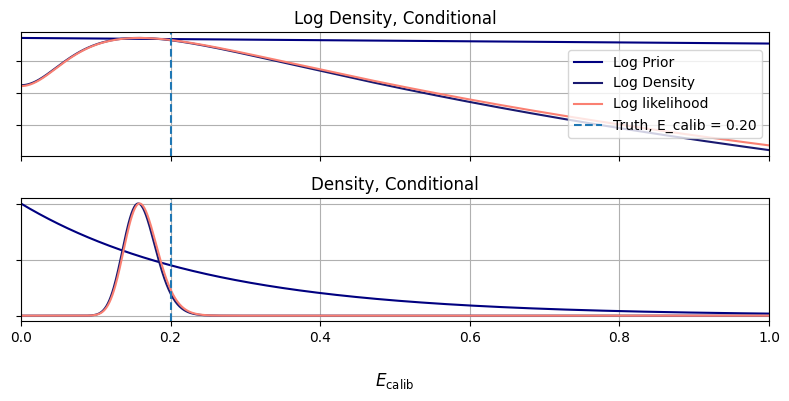

In [7]:
# Convert lightcurves to data with .lc_to_data()
data = model_instance.lc_to_data(phot_lc, spec_lc)

# Create a bunch of test samples with all parameters except E_calib fixed at truth
E_calib_test = np.linspace(0.0, 1, 1024)
test_params = dict_extend(mock_underlying.params(), {'E_calib': E_calib_test})

# Calculate prior, likelihood and log density
log_prior = model_instance.log_prior(test_params, data)
log_density = model_instance.log_density(test_params, data)
log_likelihood = log_density - log_prior

#--------------------------------
# Plot!
f, [a1, a2] = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
a1.set_yscale('log')

for a in [a1, a2]:
    a.plot(test_params['E_calib'], np.exp(log_prior - log_prior.max()), label="Log Prior", c = 'navy')
    a.plot(test_params['E_calib'], np.exp(log_density - log_density.max()), label="Log Density", c= 'midnightblue')
    a.plot(test_params['E_calib'], np.exp(log_likelihood - log_likelihood.max()), label="Log likelihood", c = 'salmon')
    a.axvline(E_calib_true, ls='--', label='Truth, E_calib = %.2f' % E_calib_true)
    a.set_yticklabels([])
    a.grid()
    if a is a1: a.legend(loc='center right')

plt.xlim(E_calib_test.min(), E_calib_test.max())
a1.set_title("Log Density, Conditional")
a2.set_title("Density, Conditional")

f.supxlabel("$E_\mathrm{calib}$")
f.tight_layout()
plt.show()

Enough validation and testing. Let's see how it performs with actual fitting via the `hessian_scan`. By default, everything should perform nice and smoothly without any alteration. Let's see how we've done:

In [8]:
my_fitter = litmus.fitting_methods.hessian_scan(model_instance, Nlags=64, verbose=False)
my_fitter.fit(phot_lc, spec_lc)

In .opt_tol, Params appear to be diverged, broken or in saddle. 

Now slotting this into a plotter and firing off the contours, we find that we've succeeded in constraining the calibration uncertainty! Notice that $E_\mathrm{calib}$ and $\ln \vert \tau \vert$ (`E_calib` and `logtau`) are slightly correlated. If we hadn't included this error calibration, we would have ended up with a model that:
1. Drastically under-estimated the timescale of variation to try and wiggle through the extra noise
2. Had a markedly lower model evidence, obscuring the strength of our lag recovery

Warning! LITMUS object built on pre-run fitting_procedure. May have unexpected behaviour. WARNING:chainconsumer:Parameter logtau in chain Lightcurves %i-%i is not constrained


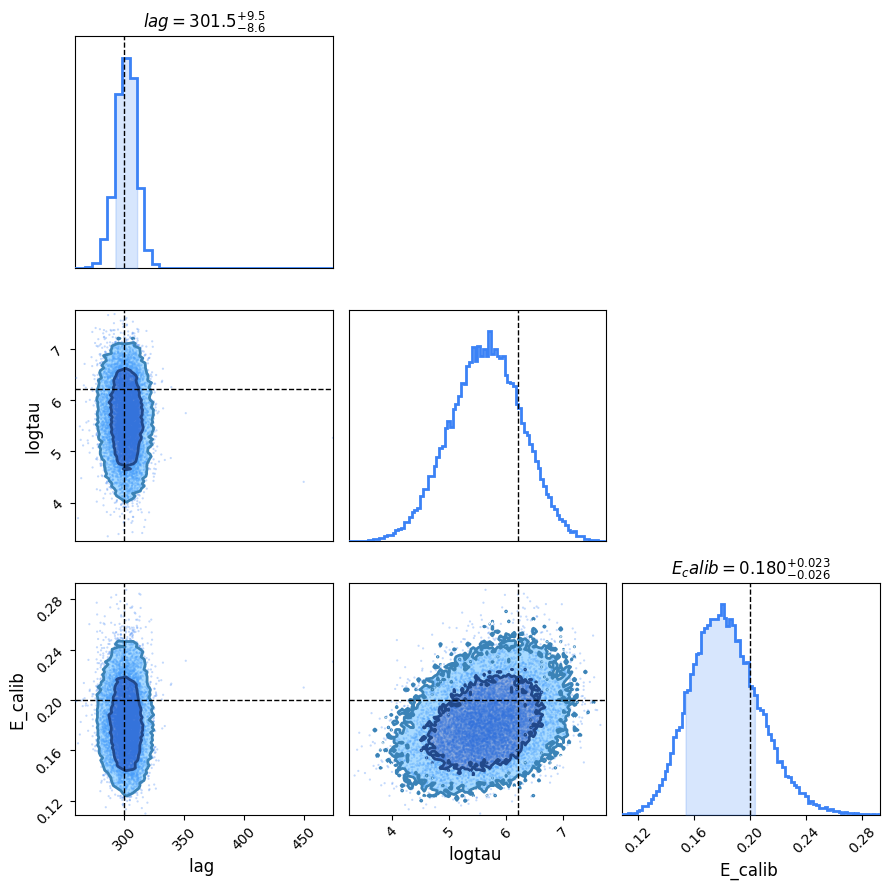

In [9]:
lt = LITMUS(my_fitter)
lt.plot_parameters(show=False, truth=mock_underlying.params() | {'E_calib': E_calib_true},
                   params=["lag", "logtau", "E_calib"])
plt.show()

This is a pretty simple example of setting up a custom `stats_model`, but by and large even more complicated applications will follow these processes. Some things not covered here are:
1. Updating the `.find_seed()` function to make common sense a-priori guesses for any new parameters you introduce. By default 
`GP_simple` or other models will blindly sample the prior until they get a decent hit for these
2. Updating `._gen_lightcurves()` to properly predict the underlying lightcurves. This is very similar to updating `model_function` but taking in an argument `Tpred` for time and returning a covariance matrix. See the source code for `GP_simple` and its null hypothesis variants for examples
3. If you decide to use a non-uniform prior for `lag`, you'll need to make sure it still has hard boundaries as defined in `prior_ranges` and will need to update `.uncon_grad_lag()` so that fitting methods understand how to transit between the constrained and unconstrained domains. See `GP_simple_normalprior` for an example.